In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [132]:
asst1 = pdr.get_data_yahoo('TSLA',start='2014-1-1', end='2015-1-1')
asst2 = pdr.get_data_yahoo('FISV',start='2014-1-1', end='2015-1-1')
bmrk = pdr.get_data_yahoo('SPY',start='2014-1-1', end='2015-1-1')
asst1 = asst1['Close']
asst2 = asst2['Close']
bmrk = bmrk['Close']
asst1.columns = ['Tesla']
asst2.columns = ['Fisv']
bmrk.columns = ['S&P 500']

In [133]:
model = regression.linear_model.OLS(bmrk,sm.add_constant(asst1)).fit() # regressing Tesla's stock prices against the benchmark
# that is S&P 500

In [134]:
print('Regression Intercept: ',model.params[0]) # calling model's intercept
print('Regression Slope: ',model.params[1]) # calling model's slope

Regression Intercept:  156.34025119633736
Regression Slope:  0.1653565915148997


In [135]:
comb = pd.concat([bmrk,asst2],axis=1) # combining two regressor for a multivariate model
comb.columns = ['S&P 500','fisc'] # renaming the columns
model1 = regression.linear_model.OLS(asst1,sm.add_constant(comb)).fit() # developing a multivariate OLS model to predict Tesla
# stock price using two independent variables S&P 500 and Finserv

In [136]:
print('Regression Intercept: ',model1.params[0]) # calling the intercept
print('Regression Slope for S&P 500: ',model1.params[1]) # calling the slope of the model
print('Regression Slope for fisv: ',model1.params[2]) # calling the slope of the model

Regression Intercept:  -329.16413714709086
Regression Slope for S&P 500:  3.8163618452600456
Regression Slope for fisv:  -5.957065262844782


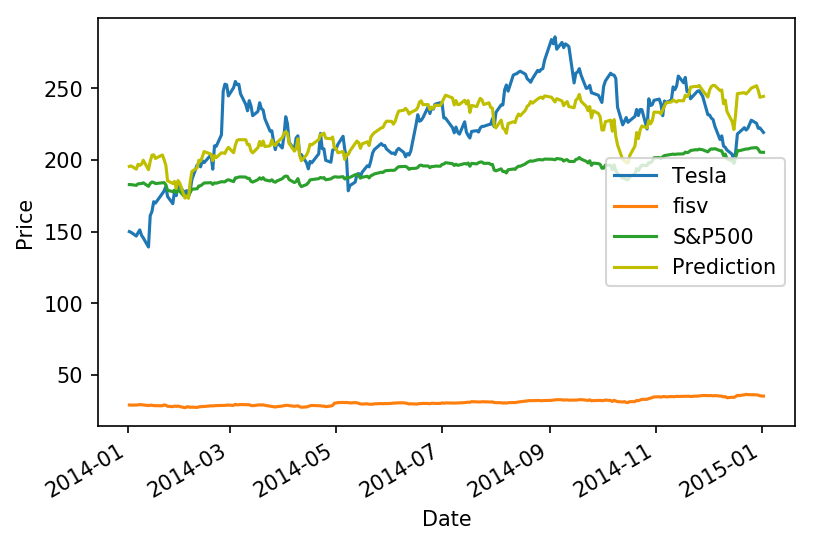

In [137]:
prediction = model1.params[0] + model1.params[1]*bmrk + model1.params[2]*asst2
plt.plot(asst1)
plt.plot(asst2)
plt.plot(bmrk)
prediction.plot(color='y')
plt.legend(['Tesla','fisv','S&P500','Prediction'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.rcParams['figure.dpi']=150; # to get a bigger visualization

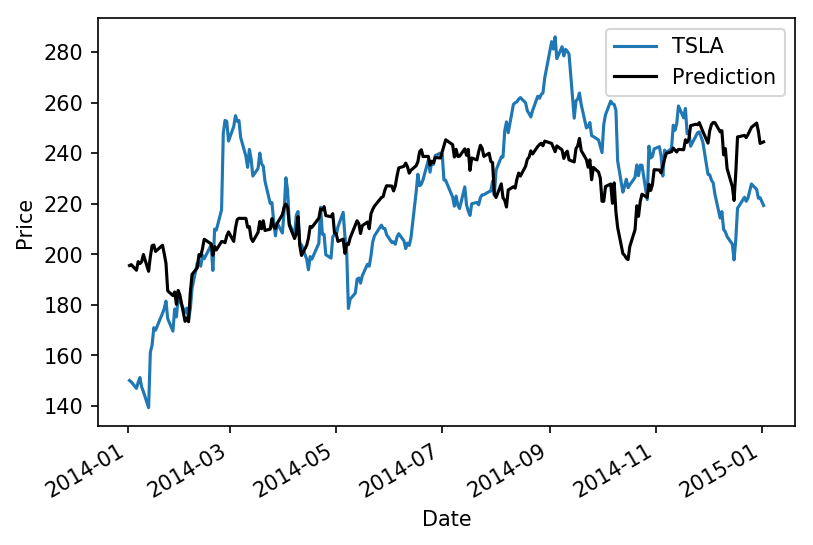

In [64]:
plt.plot(asst1) # this to to have a closer look at the prediction and dependent variable
prediction.plot(color='0')
plt.legend(['TSLA','Prediction'])
plt.xlabel('Date')
plt.ylabel('Price');

In [138]:
model1.summary() # syntax to call the summary of the OLS model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     82.00
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.14e-28
Time:                        17:00:22   Log-Likelihood:                -1148.7
No. Observations:                 253   AIC:                             2303.
Df Residuals:                     250   BIC:                             2314.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -329.1641     48.437     -6.796      0.000    -424.561    -233.768
S&P 500        3.8164      0.459      8.317      0.000       2.913       4.720
fisc          -5.9571      1.535     -3.880      0.000      -8.981      -2.933
==============================================================================
Omnibus:                        9.980   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                4.898
Skew:                           0.066   Prob(JB):                       0.0864
Kurtosis:                       2.331   Cond. No.                     6.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

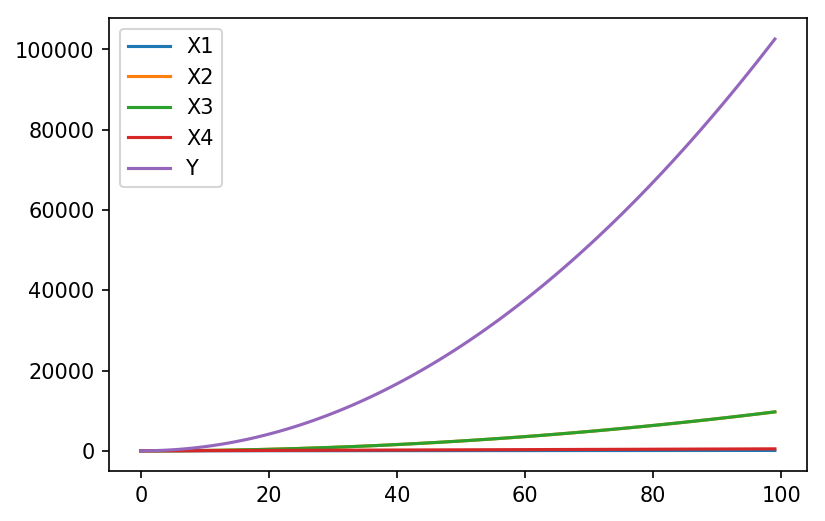

In [139]:
X1 = np.arange(100) # creatin variables to run a forward stepwise model to find the best fit
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend();

In [70]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print ("Beta_0: ", results.params[0])
print ("Beta_1: ", results.params[1])
print ("Beta_2: ", results.params[2])
print ("Beta_3: ", results.params[3])
print ("Beta_4: ", results.params[4])

Beta_0:  8.640199666842818e-12
Beta_1:  0.2692307692307008
Beta_2:  0.5000000000045475
Beta_3:  9.999999999995907
Beta_4:  1.3461538461539106


In [125]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')

In [140]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    
    # Initialize some variables
    explanatory = list(data.columns) # lists all the variables
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept") # create a colum with 100 values all one (1)
    current_score, best_new_score = np.inf, np.inf # setting scores to infinity to run the function

    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0: # this loop will run four times. Each time it will run
        # the regression model on the remaining regresors. Initially it will run wil all four regressors and pop the best one
        # in each loop and put that regressor in the final model. after four loops we shall have the best model that we will    
        # use for final running our final model 
        scores_with_elements = []
        count = 0
        
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(Y, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index) # pop the best one
            selected = pd.concat([selected, data[best_element]],axis=1) # include in out model
            current_score = best_new_score
    
    # Return the final model
    model = regression.linear_model.OLS(Y, selected).fit()
    return model

In [141]:
result=forward_aic(Y,data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.197e+27
Date:                Sun, 22 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:12:03   Log-Likelihood:                 1864.6
No. Observations:                 100   AIC:                            -3721.
Df Residuals:                      96   BIC:                            -3711.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.819e-11   1.36e-09      0.013      0.989   -2.68e-09    2.72e-09
X3            10.0000   8.24e-10   1.21e+10      0.000      10.000      10.000
X4             1.3462   1.26e-11   1.07e+11      0.000       1.346       1.346
X2             0.5000   8.23e-10   6.07e+08      0.000       0.500       0.500
X1             0.2692   2.52e-12   1.07e+11      0.000       0.269       0.269
==============================================================================
Omnibus:                       13.944   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.091
Skew:                           0.655   Prob(JB):                      0.00644
Kurtosis:                       2.161   Cond. No.                     6.78e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.29e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""